# Burgers Equation with Physics-Informed Neural Network (PINN)

In [313]:
%reset -f

# from phi.jax.flow import *        ## Phiflow was ultimately not needed
# from phi.jax.stax.flow import *

import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import os

# import functools
import pylab as plt
from utils import plot
import time

key = jax.random.PRNGKey(46)     ## Use same random points for all iterations

## Building the network
A simple MLP with around 3000 learnable params, with `tanh` activation after layers.

In [314]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        inputs = jnp.concatenate([x, t], axis=-1)
        y = nn.Dense(2)(inputs)
        for _ in range(0, 8):
            y = nn.Dense(20)(y)
            y = nn.tanh(y)          ## Don't use ReLU !!!!
        return nn.Dense(1)(y)

def init_flax_params(net:nn.Module):
    init_data = jnp.ones((1,)), jnp.ones((1,))
    params = net.init(key, *init_data)
    print(net.tabulate(key, *init_data, depth=8, console_kwargs={"force_jupyter":False}))
    return params

pinn = MLP()
params = init_flax_params(pinn)


                               MLP Summary                                
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs     ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ - float64[1] │ float64[1]  │                        │
│         │        │ - float64[1] │             │                        │
├─────────┼────────┼──────────────┼─────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float64[2]   │ float64[2]  │ bias: float32[2]       │
│         │        │              │             │ kernel: float32[2,2]   │
│         │        │              │             │                        │
│         │        │              │             │ 6 (24 B)               │
├─────────┼────────┼──────────────┼─────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float64[2]   │ float64[20] │ bias: float32[20]      │
│         │        │    

Let's generate a small meshgrid and plot the predicted scalar field obtained from an untrained neural network.

Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


/var/folders/fm/dr9q5mc50ql8h2wmv7b1fmz80000gn/T/ipykernel_8768/329991808.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)


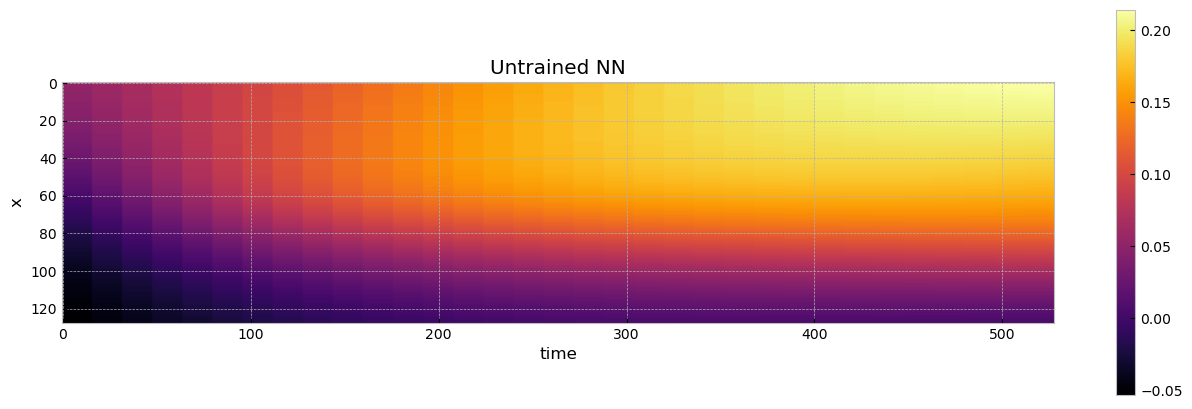

In [315]:
N=128
grids_xt = np.meshgrid(np.linspace(-1, 1, N), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [jnp.array(arr, dtype=jnp.float32)[:, :, jnp.newaxis] for arr in grids_xt]

# create 4D tensor with batch dimension in addition to space, time, and channel
grid_u = jnp.tile(pinn.apply(params, grid_x, grid_t), (1,1,1,1))

print("Size of grid_u: "+format(grid_u.shape))

def show_state(a, title):
    for i in range(4): a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)

print("Randomly initialized network state:")
show_state(grid_u,"Untrained NN")

## Define boundary conditions

In [316]:
def boundary_tx(N):     ## Basically optimal control: Strictly speaking, this is not needed !
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation (available on the website: https://physicsbaseddeeplearning.org/physicalloss-code.html)
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = jnp.ones_like(x) * 0.5
    perm = np.random.permutation(128)
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = jax.random.uniform(key, (N,), minval=-1, maxval=1)
    t = jnp.zeros_like(x)
    u = - jnp.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = jax.random.uniform(key, (N,), minval=-1, maxval=1, dtype=jnp.float32)
    x = jnp.concatenate([jnp.zeros((N//2,)) + 1, jnp.zeros((N//2,)) - 1])
    u = jnp.zeros([N])
    return x, t, u

Now we can create the data points needed for training the PINN: 100 on the open boundary (at $x=\pm 1$), 100 for the other kind of boundary (at $t=0.5$), and 1000 for the inner points (where the PDE physics is observed, i.e. where we have both $x$ and $t$).

In [317]:
# Boundary data
N_SAMPLE_POINTS_BND = 100
x_bc, t_bc, u_bc = [jnp.concatenate([v_t05, v_t0]) for v_t05, v_t0 in zip(boundary_tx(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
# x_bc, t_bc, u_bc = [jnp.concatenate([v_t0, v_t05]) for v_t0, v_t05 in zip(_ALT_t0(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
x_bc, t_bc, u_bc =  x_bc[:, jnp.newaxis], t_bc[:, jnp.newaxis], u_bc[:, jnp.newaxis]

# Physical data inside of domain
N_SAMPLE_POINTS_INNER = 1000
x_ph, t_ph = jax.random.uniform(key, (N_SAMPLE_POINTS_INNER,), minval=-1, maxval=1), jax.random.uniform(key, (N_SAMPLE_POINTS_INNER,), minval=0, maxval=1)
x_ph, t_ph = x_ph[:, jnp.newaxis], t_ph[:, jnp.newaxis]

## Training

In [318]:
## Optimizer
scheduler = optax.linear_schedule(init_value=1e-1, end_value=1e-5, transition_steps=10000)
optimizer = optax.sgd(learning_rate=scheduler)

## Flax training state
state = train_state.TrainState.create(apply_fn=pinn.apply,
                                        params=params,
                                        tx=optimizer)

In [319]:
@jax.grad
def u_t(t, x, params):
    return pinn.apply(params, x, t)[0]      ## Scalar output

@jax.grad
def u_x(x, t, params):
    return pinn.apply(params, x, t)[0]

@jax.grad
def u_xx(x, t, params):
    return u_x(x, t, params)[0]

def residual(params, x, t):
    """ Physics-based loss function with Burgers equation """
    u_ = pinn.apply(params, x, t)
    u_t_ = jax.vmap(u_t, in_axes=(0, 0, None), out_axes=0)(t, x, params)
    u_x_ = jax.vmap(u_x, in_axes=(0, 0, None), out_axes=0)(x, t, params)
    u_xx_ = jax.vmap(u_xx, in_axes=(0, 0, None), out_axes=0)(x, t, params)
    return u_t_ + u_*u_x_ - (0.01 / np.pi) * u_xx_

def loss_fn(params, x_bc, t_bc, u_bc, x_ph, t_ph):
    u_bc_pred = pinn.apply(params, x_bc, t_bc)
    loss_u = optax.l2_loss(u_bc_pred - u_bc)        ## Data loss

    res = residual(params, x_ph, t_ph)
    loss_ph = optax.l2_loss(res)                    ## Residual loss

    eps = 1.00
    return jnp.mean(loss_u) + eps*jnp.mean(loss_ph)

In [320]:
@jax.jit
def train_step(state, x_bc, t_bc, u_bc, x_ph, t_ph):
    grads = jax.grad(loss_fn)(state.params, x_bc, t_bc, u_bc, x_ph, t_ph)
    state = state.apply_gradients(grads=grads)
    loss = loss_fn(state.params, x_bc, t_bc, u_bc, x_ph, t_ph)
    return state, loss

epochs = 10000
history_loss = []   # data for plotting
if os.path.isfile("./temp/pinn_checkpoint_"+str(state.step)):
    print("Found existing network, loading & skipping training")
    state = checkpoints.restore_checkpoint(ckpt_dir="./temp/", prefix="pinn_checkpoint_", target=state)
else:
    print("Training from scratch")
    for epoch in range(epochs+1):
        state, loss = train_step(state, x_bc, t_bc, u_bc, x_ph, t_ph)
        history_loss.append(loss)

        if epoch<3 or epoch%1000==0:
            print("Epoch: %-5d                Loss: %.6f" % (epoch, loss))

checkpoints.save_checkpoint("./temp/", prefix="pinn_checkpoint_", target=state, step=state.step, overwrite=True)
print("Training done, saved network")

Training from scratch
Epoch: 0                    Loss: 0.083954
Epoch: 1                    Loss: 0.083119
Epoch: 2                    Loss: 0.082826
Epoch: 1000                 Loss: 0.039884
Epoch: 2000                 Loss: 0.019133
Epoch: 3000                 Loss: 0.015535
Epoch: 4000                 Loss: 0.016287
Epoch: 5000                 Loss: 0.010908
Epoch: 6000                 Loss: 0.007409
Epoch: 7000                 Loss: 0.006377
Epoch: 8000                 Loss: 0.001734
Epoch: 9000                 Loss: 0.000969
Epoch: 10000                Loss: 0.000873
Training done, saved network


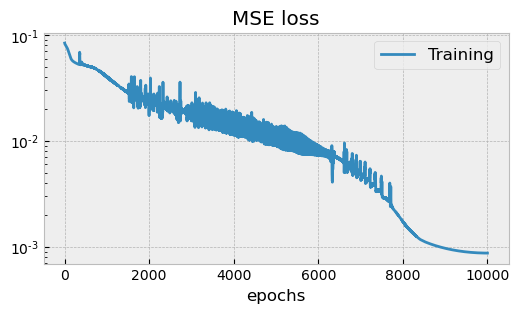

In [321]:
ax = plot(history_loss, label='Training', x_label='epochs', title='MSE loss', figsize=(6,3))

/var/folders/fm/dr9q5mc50ql8h2wmv7b1fmz80000gn/T/ipykernel_8768/329991808.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)


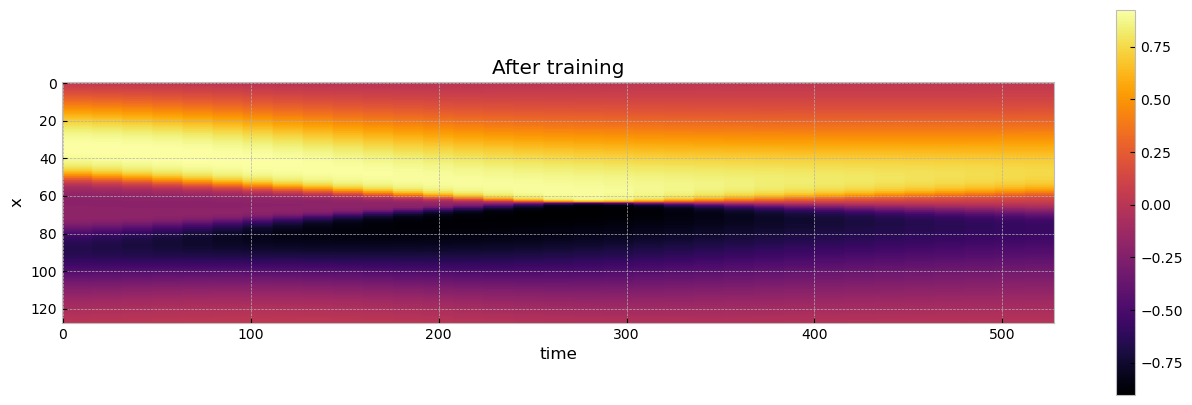

In [326]:
u = jnp.tile(pinn.apply(state.params, grid_x, grid_t), (1,1,1,1))
show_state(u, "After training")

## Evaluation

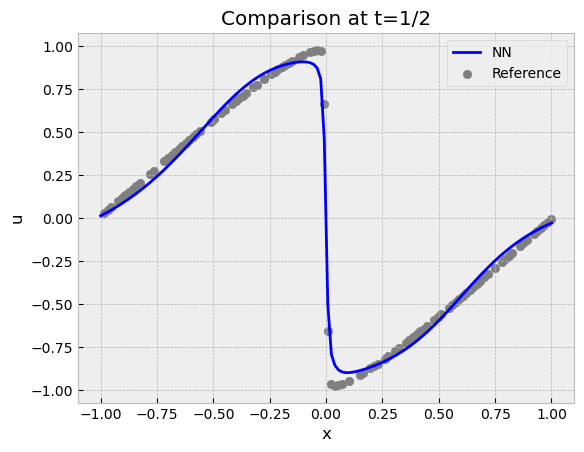

In [327]:
# solution is imposed at t=1/2 , which is 16 in the array
BC_TX = 16
uT = u[0,:,BC_TX,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(uT)), uT, lw=2, color='blue', label="NN")
fig.scatter(x_bc[0:100], u_bc[0:100], color='gray', label="Reference")
plt.title("Comparison at t=1/2")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

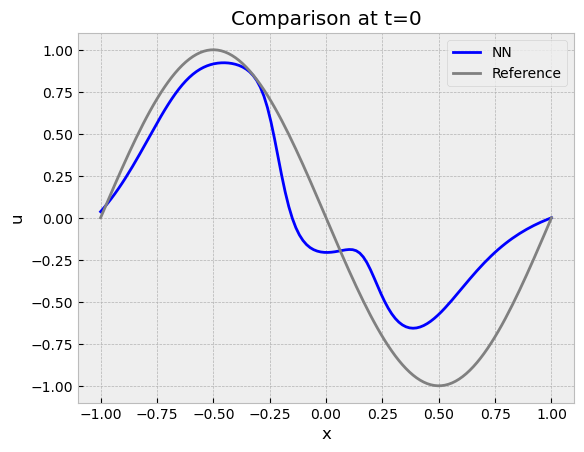

In [328]:
# ground truth solution at t0
t0gt = np.asarray( [ [-jnp.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,N)] )
velP0 = u[0,:,0,0]

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(velP0)), velP0, lw=2, color='blue', label="NN")
fig.plot(np.linspace(-1,1,len(t0gt)), t0gt, lw=2, color='gray', label="Reference")
plt.title("Comparison at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend()

## Findings
- Don't use ReLU in your PINN arcitecture, use tanh, as it works miles better
- Not that easy to get the answer we want

## Next steps
- Try to actually use phiflow here, because it isn't used at all
- Look at integrating differentiable physics
- Do some optimal control, and make sure you include differentiable physics to easily compute the Lagrangian
- Do some closed loop control with PINNs